<a href="https://colab.research.google.com/github/KonsumGandalf/proccessMining/blob/main/proccessMining/src/data/course_python_data/3_6ConformanceChecking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
%pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 205 kB 52.9 MB/s 
     |████████████████████████████████| 70 kB 7.5 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23593 sha256=44fcf2faa1e4be749a3a7f683f8aec6891dead59425627ecb2b266becba504a6
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [ ]:
# Process Discovery

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.batches import algorithm 

# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [ ]:
# Uplaod small source files
from google.colab import files
uploaded = files.upload()

#print(uploaded)

In [ ]:
# Load Event Log
log_csv = pd.read_csv('ArtificialPatientTreatmentV3.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

log_csv = log_csv.sort_values('datetime')

log_csv.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'} # identify the case_id_key name (if not change it will simply be the mane of the coloumn)

# Covert the dataframe to an event log dictionary 

event_log = log_converter.apply(log_csv, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

FileNotFoundError: ignored

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

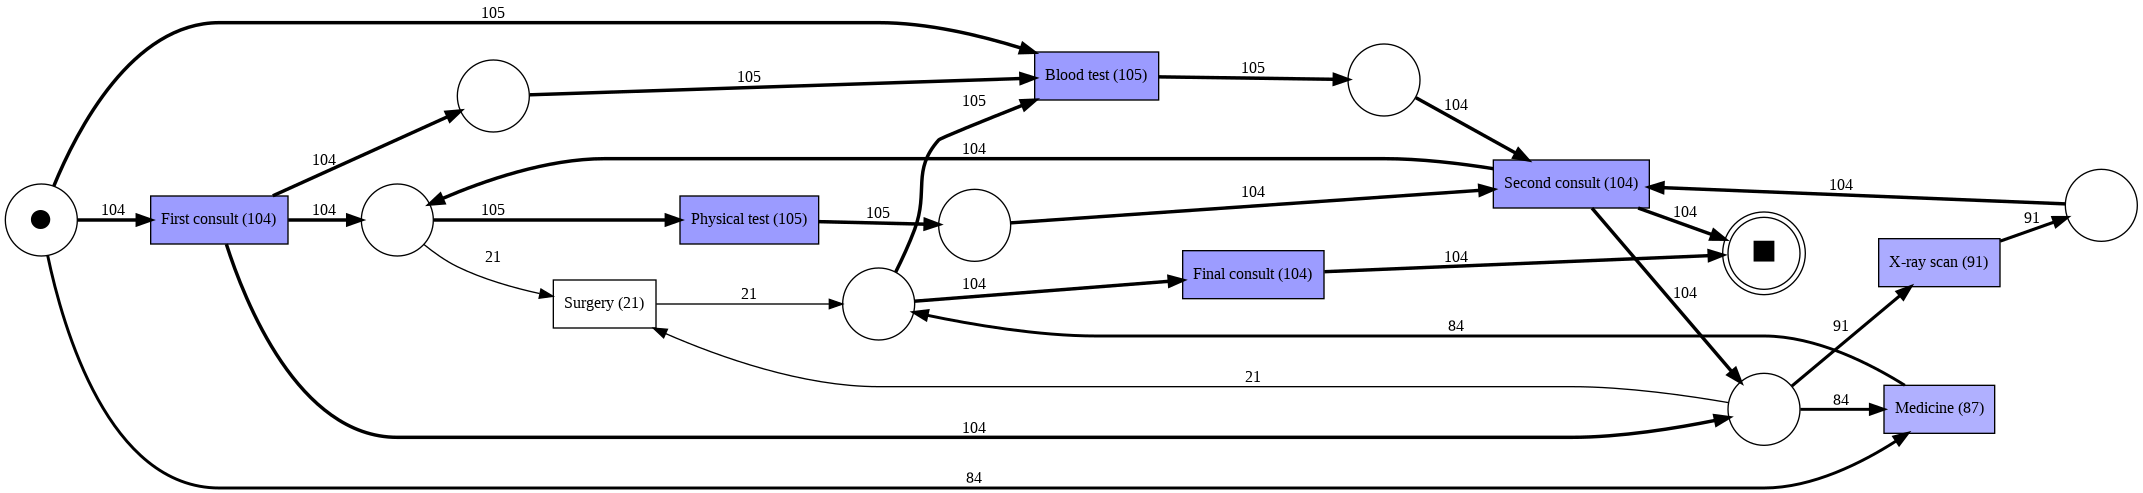

In [ ]:
# Discover a Petri Net using Alpha Miner
net, im, fm = alpha_miner.apply(event_log)
# Visualise 
gviz = pn_visualizer.apply(net, im, fm, variant=pn_visualizer.Variants.FREQUENCY, log=event_log)
pn_visualizer.view(gviz)

In [ ]:
# Discover a Petri Net using Heuristic Miner
parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 3, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 3} 
net, im, fm = heuristics_miner.apply(event_log, parameters=parameters)
# Visualise a Petri Net
gviz = pn_visualizer.apply(net, im, fm, log=event_log)
pn_visualizer.view(gviz)

NameError: ignored

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

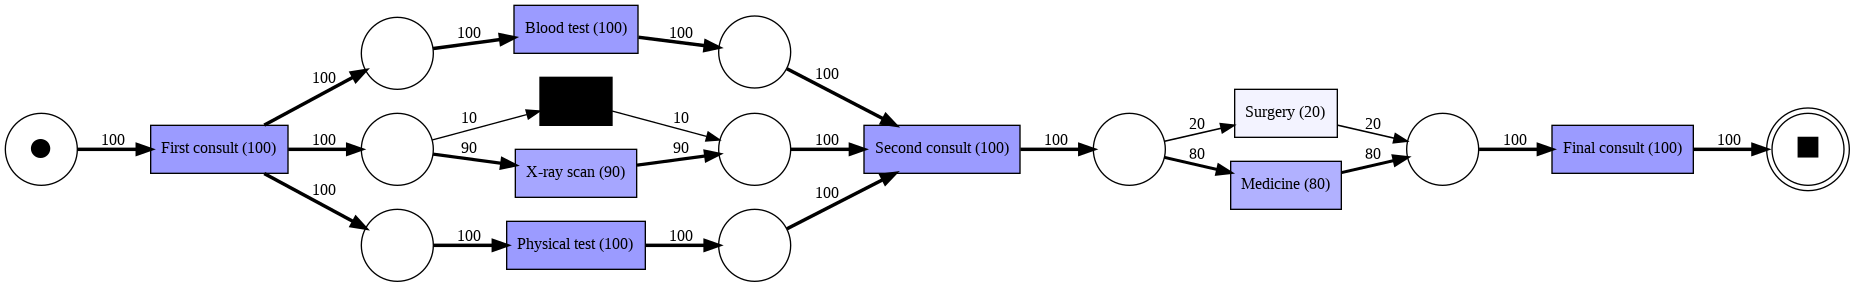

In [ ]:
# Discover process tree using Inductive Miner Infrequent
# Produces a more precise model, without fitness guarantees, by eliminating some behavior.
tree = inductive_miner.apply_tree(event_log)

# Convert process tree into a Petri Net
net, im, fm = pt_converter.apply(tree)
## Visualise
gviz = pn_visualizer.apply(net, im, fm, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('Fitness: ', fitness)

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Precision: ', prec)

gen = generalization_evaluator.apply(event_log, net, im, fm)
print('Generalization: ', gen)

simp = simplicity_evaluator.apply(net)
print('Simplicity: ', simp)

replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/57 [00:00<?, ?it/s]

Precision:  0.3439490445859873


replaying log with TBR, completed variants ::   0%|          | 0/19 [00:00<?, ?it/s]

Generalization:  0.8449083333633648
Simplicity:  0.6603773584905661


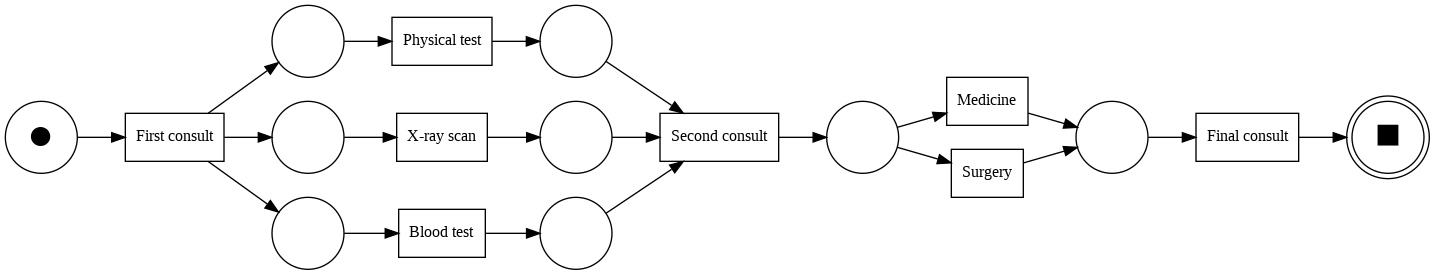

In [ ]:
## import BPMN and PMNL files

from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

bpmn_graph = pm4py.read_bpmn('diagram2.bpmn')

net, im, fm = bpmn_converter.apply(bpmn_graph)

## Visualise
gviz = pn_visualizer.apply(net, im, fm, 
                           #variant=pn_visualizer.Variants.FREQUENCY, 
                           #log=event_log
                           )
pn_visualizer.view(gviz)

In [ ]:
# Conformance Cheking
# Token-based replay matches a trace and a Petri net model,
# Alignment-based replay aims to find one of the best alignment between the trace and the model.

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

In [ ]:
# Token-based replay matches a trace and a Petri net model,

replayed_traces = token_replay.apply(event_log, net, im, fm)


print("REPLAY")
print("Number of traces", len(replayed_traces))

#print("Case", event_log[0].attributes['concept:name'])

anomalous_traces = []
i = 0
while i < len(replayed_traces):
	if replayed_traces[i]["trace_fitness"] < 1:
		anomalous_traces.append(event_log[i].attributes["concept:name"])
	i += 1
# print the list as a string
print(', '.join(map(str, anomalous_traces)))
print("Number of anomalous traces ", len(anomalous_traces))

print("Percentage of anomalous traces", (len(anomalous_traces)/len(replayed_traces))*100 , '%')


replaying log with TBR, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

REPLAY
Number of traces 108
Case patient0
patient100, patient101, patient102, patient103, patient104, patient106, patient107
Number of anomalous traces  7
Percentage of anomalous traces 6.481481481481481 %


In [ ]:
# Alignment-based replay aims to find one of the best alignment between the trace and the model.

aligned_traces = alignments.apply_log(event_log, net, im, fm)

print("ALIGNMENTS")
print("Number of traces", len(aligned_traces))

#print(aligned_traces)

anomalous_traces = []
i = 0
while i < len(aligned_traces):
	if aligned_traces[i]["fitness"] != 1:
		#anomalous_traces.append(event_log[i].attributes["concept:name"])
		anomalous_traces.append(aligned_traces[i]['alignment'])
	i += 1
# print the list as a string
#print(', '.join(map(str, anomalous_traces)))
print(anomalous_traces)
print("Number of anomalous traces ", len(anomalous_traces))

print("Percentage of anomalous traces", (len(anomalous_traces)/len(aligned_traces))*100 , '%')


aligning log, completed variants ::   0%|          | 0/22 [00:00<?, ?it/s]

ALIGNMENTS
Number of traces 108
[[('First consult', 'First consult'), ('>>', 'X-ray scan'), ('Blood test', 'Blood test'), ('Physical test', 'Physical test'), ('Second consult', 'Second consult'), ('Surgery', 'Surgery'), ('Final consult', 'Final consult')], [('First consult', 'First consult'), ('>>', 'X-ray scan'), ('Physical test', 'Physical test'), ('Blood test', 'Blood test'), ('Second consult', 'Second consult'), ('Surgery', 'Surgery'), ('Final consult', 'Final consult')], [('First consult', 'First consult'), ('>>', 'X-ray scan'), ('Physical test', 'Physical test'), ('Blood test', 'Blood test'), ('Second consult', 'Second consult'), ('Medicine', 'Medicine'), ('Final consult', 'Final consult')], [('First consult', 'First consult'), ('>>', 'X-ray scan'), ('Physical test', 'Physical test'), ('Blood test', 'Blood test'), ('Second consult', 'Second consult'), ('Medicine', 'Medicine'), ('Final consult', 'Final consult')], [('First consult', 'First consult'), ('>>', 'X-ray scan'), ('Physic